In [445]:
# Please install openpyxl and odfpy from pip or anaconda in order to import the inout data files
import sys
# !{sys.executable} -m pip install openpyxl
# !{sys.executable} -m pip install odfpy

# Import libraries and set plot styles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warning for chained assignment
pd.options.mode.chained_assignment = None  # default='warn'

# Show plots inline
%matplotlib inline

# Set plot style
# plot.style.available
plt.style.use('fivethirtyeight')

In [446]:
# Read in and preview data
df = pd.read_csv('/Users/FM/Public/HDS/Summer Project/wastewater_r_estimation/Data/agg_data_inner_11_cis_mar22.csv',
                 parse_dates=['date'],
                 dayfirst=True)
df1 = pd.read_excel('/Users/FM/Public/HDS/Summer Project/wastewater_r_estimation/Data/Region Mapping.xlsx')
df2 = pd.read_excel('/Users/FM/Public/HDS/Summer Project/R_and_growth_rate_time_series_for_publication_v1.0.ods',
                    sheet_name=2,
                    engine='odf',
                    header=[7,8], #Two rows of header
                    na_values='.'
                    )
real_cases = pd.read_csv("/Users/FM/Public/HDS/Summer Project/local files/region_2022-07-01.csv")
region_weights = pd.read_excel("/Users/FM/Public/HDS/Summer Project/wastewater_r_estimation/Data/Region Intersection.xlsx",
                                sheet_name=0)
region_weights = region_weights.iloc[:, [1,18,25]]

# Check for missing values
df.isnull().sum()

# Select header titles and data range
df1.columns = df1.iloc[2]
region_map = df1.iloc[3:, :]
r_val = df2.iloc[:, 1:]

# Merge 2 header rows
r_val.columns = ['_'.join(header).upper() for header in r_val.columns]
r_val.drop(['UK_UPPER BOUND', 'UK_LOWER BOUND'], axis=1)

# Remove missing values
region_map.dropna()
r_val = r_val.dropna()

# Rename specific columns for joining
df.rename(columns={'cis20cd': 'CIS20CD'}, inplace=True)
df.rename(columns={'grab_compo_boo': 'compo_frac'}, inplace=True)
region_map.rename(columns={'Geography Code': 'CIS20CD', 'Region': 'region'}, inplace=True)
r_val.rename(columns={'DATE_UNNAMED: 1_LEVEL_1': 'date'}, inplace=True)
region_weights.rename(columns={'nhser20nm': 'nhs_region', 'NAME': 'region'}, inplace=True)

# Lower case all strings for easy joining
region_map['region'] = region_map['region'].str.lower()
real_cases['areaName'] = real_cases['areaName'].str.lower()
region_weights['region'] = region_weights['region'].map(lambda x: str(x)[:-15].lower())
region_weights['region'] = region_weights['region'].str.replace('eastern','east of england')
region_weights['nhs_region'] = region_weights['nhs_region'].str.lower()

### Copied from UKHSA code ###
# Variable labels that are not changed
variable_labels = {
    'sars_cov2_gc_l_mean': 'SARS-CoV-2 concentration',
    'sample_ph_pre_ansis':'sample pH',
    'ammonia_mg_l':'ammonia concentration',
    #'control_gc_l_mean':'control volume',
    'ophosph_mg_l':'phosphate concentration',
    'suspended_solids_mg_l':'suspended solids',
    'sars_below_loq':'below LOQ',
    'sars_below_lod':'below LOD',
    'compo_frac':'composites fraction',
    'reception_delay':'reception delay',
    'catch_cis_population':'covered population',
    'catch_in_cis_prop':'subregion population fraction',
    "catchment_population_ons_mid_2019": "catchment population",
    "catchment_area": 'catchment area'
}

In [447]:
df['date'] = pd.to_datetime(df['date'])
# tmp = pd.to_datetime(r_val['date'],
#                      format = '%Y-%m-%d %H:%M:%S',
#                      errors='coerce')
# r_val.date = r_val.date.where(tmp.isna(), tmp.dt.date)
r_val['date'] = pd.to_datetime(r_val['date'])
real_cases['date'] = pd.to_datetime(real_cases['date'])
real_cases = real_cases[real_cases['date'].between('2020-09-11', '2021-02-10')]

# df.head()
# region_map.head()
# r_val.head()
# region_weights

# Check R values shortly before study period (for out-of-range interpolation)
# r_val[r_val['date'].between('2020-08-20','2020-09-07')]

### Generate average r values for each region

In [448]:
# r_val['UK_AVERAGE'] = r_val[['UK_LOWER BOUND', 'UK_UPPER BOUND']].mean(axis=1)
r_val['ENGLAND_AVERAGE'] = r_val[['ENGLAND_LOWER BOUND', 'ENGLAND_UPPER BOUND']].mean(axis=1)
r_val['EAST OF ENGLAND_AVERAGE'] = r_val[['EAST OF ENGLAND_LOWER BOUND', 'EAST OF ENGLAND_UPPER BOUND']].mean(axis=1)
r_val['LONDON_AVERAGE'] = r_val[['LONDON_LOWER BOUND', 'LONDON_UPPER BOUND']].mean(axis=1)
r_val['MIDLANDS_AVERAGE'] = r_val[['MIDLANDS_LOWER BOUND', 'MIDLANDS_UPPER BOUND']].mean(axis=1)
r_val['NORTH EAST AND YORKSHIRE_AVERAGE'] = r_val[['NORTH EAST AND YORKSHIRE_LOWER BOUND', 'NORTH EAST AND YORKSHIRE_UPPER BOUND']].mean(axis=1)
r_val['NORTH WEST_AVERAGE'] = r_val[['NORTH WEST_LOWER BOUND', 'NORTH WEST_UPPER BOUND']].mean(axis=1)
r_val['SOUTH EAST_AVERAGE'] = r_val[['SOUTH EAST_LOWER BOUND', 'SOUTH EAST_UPPER BOUND']].mean(axis=1)
r_val['SOUTH WEST_AVERAGE'] = r_val[['SOUTH WEST_LOWER BOUND', 'SOUTH WEST_UPPER BOUND']].mean(axis=1)

# Export averages of R
melt_r = pd.melt(r_val[['date', 'ENGLAND_AVERAGE', #'ENGLAND_LOWER BOUND', 'ENGLAND_UPPER BOUND',
                        'EAST OF ENGLAND_AVERAGE', #'EAST OF ENGLAND_LOWER BOUND', 'EAST OF ENGLAND_UPPER BOUND',
                        'LONDON_AVERAGE', #'LONDON_LOWER BOUND', 'LONDON_UPPER BOUND',
                        'MIDLANDS_AVERAGE', #'MIDLANDS_LOWER BOUND', 'MIDLANDS_UPPER BOUND',
                        'NORTH EAST AND YORKSHIRE_AVERAGE', #'NORTH EAST AND YORKSHIRE_LOWER BOUND',
                        #'NORTH EAST AND YORKSHIRE_UPPER BOUND',
                        'NORTH WEST_AVERAGE', #'NORTH WEST_LOWER BOUND', 'NORTH WEST_UPPER BOUND',
                        'SOUTH EAST_AVERAGE', #'SOUTH EAST_LOWER BOUND', 'SOUTH EAST_UPPER BOUND',
                        'SOUTH WEST_AVERAGE', #'SOUTH WEST_LOWER BOUND', 'SOUTH WEST_UPPER BOUND'
                        ]],
                 id_vars=['date'])

# Create column for join
melt_r['nhs_region'] = melt_r['variable'].map(lambda x: str(x)[:-8].lower())
melt_r.to_csv("r_val_cleaned.csv")

### Linkage

In [449]:
# Match region to codes in wastewater data
df3 = pd.merge(df, region_map[['CIS20CD', 'Country', 'region']], on='CIS20CD', how='left')

# Weighted average
grouped = df3.groupby(['region', 'date'])

def wavg(group):
    d = group['sars_cov2_gc_l_mean']
    w = group['catchment_population_ons_mid_2019']
    return ((d * w).sum() / w.sum()), ((d * w).sum()*400)
    # weighted average of RNA level and
    # Gene copies per day assuming 400L/person/d

df4= grouped.apply(wavg)
df4 = df4.reset_index()
df4.rename(columns={0: 'temp'}, inplace=True) # rename weighted average column
df4['weighted_avg_sars_cov2'], df4['gene_copies_per_day'] = zip(*df4.temp) # separate into two columns
df4 = df4.drop(columns='temp')

# Number of regions in RNA data
df3.region.nunique()

9

In [450]:
# Join average R estimates (7 NHS regions) and weights of 9 regions
df5 = pd.merge(melt_r, region_weights, on='nhs_region', how='left')

In [451]:
# Weighted average of average R values *To-do: Upper bound and Lower bound
grouped2 = df5.dropna().groupby(['region', 'date'])

def wavg2(group):
    d = group['value']
    w = group['Area']
    return (d * w).sum() / w.sum()

weighted_r = grouped2.apply(wavg2)
weighted_r = weighted_r.reset_index()
weighted_r.rename(columns={0: 'weighted_average_r'}, inplace=True) # rename weighted average column

# Check number of regions
weighted_r.region.nunique()

# Export
weighted_r.to_csv("weighted_r.csv")

In [452]:
# Match with R values
model_dataset = pd.merge(df4, weighted_r, on=['date', 'region'], how='left')

# Merge with all variables
all_var_dataset = pd.merge(df4, df, on='date', how='left').dropna()
all_var_dataset.to_csv("all_var_dataset.csv")

In [453]:
# # Dimension of dataframe
# model_dataset.shape
#
# # Number of unique sites
# model_dataset.region.nunique()
#
# # Date range
# print('Study period from', model_dataset.date.min(), 'to', model_dataset.date.max())

# Get total population of each region for each unique date
population_sum = grouped['catchment_population_ons_mid_2019'].sum()
population_sum.to_csv('Population Over Time.csv')

In [454]:
model_dataset.region.unique()

array(['east midlands', 'east of england', 'london', 'north east',
       'north west', 'south east', 'south west', 'west midlands',
       'yorkshire and the humber'], dtype=object)

#### Subsets

In [455]:
# # Create a class object holding all subsets (not sure how to perform interpolation over it, tbc)
# class model_dataset_names:
#     pass
#
# subset_model_dataset = model_dataset_names()
#
# subsets = model_dataset['region'].unique()
#
# for subset in subsets:
#     setattr(subset_model_dataset, f"{subset}", model_dataset[model_dataset['region']==subset].reset_index(drop=True))
#
# for subset in subsets:
#     print(getattr(subset_model_dataset, f"{subset}"))

In [456]:
subset_sw = model_dataset.loc[(model_dataset['region'] == 'south west'),:]
subset_se = model_dataset.loc[(model_dataset['region'] == 'south east'),:]
subset_ldn = model_dataset.loc[(model_dataset['region'] == 'london'),:]
subset_ee = model_dataset.loc[(model_dataset['region'] == 'east of england'),:]
subset_em = model_dataset.loc[(model_dataset['region'] == 'east midlands'),:]
subset_wm = model_dataset.loc[(model_dataset['region'] == 'west midlands'),:]
subset_nw = model_dataset.loc[(model_dataset['region'] == 'north west'),:]
subset_ne = model_dataset.loc[(model_dataset['region'] == 'north east'),:]
subset_yh = model_dataset.loc[(model_dataset['region'] == 'yorkshire and the humber'),:]

In [457]:
subsets = [subset_sw, subset_se, subset_ldn, subset_ee, subset_em, subset_wm, subset_nw, subset_ne, subset_yh]
subsets[1]['region']

467    south east
468    south east
469    south east
470    south east
471    south east
          ...    
569    south east
570    south east
571    south east
572    south east
573    south east
Name: region, Length: 107, dtype: object

#### Perform interpolation into daily data

In [458]:
def interpolation(subset):
    # Set index as date to perform interpolation
    subset.index = subset['date']
    # del subset['date']

    # Linear interpolation
    daily_interpol = subset.resample('D').mean().interpolate('linear')
    # daily_interpol['sars_cov2_gc_l_mean']=daily_interpol['sars_cov2_gc_l_mean'].interpolate()

    # This would remove the first rows without interpolated r values -> to be fixed
    daily_interpol = daily_interpol.dropna().reset_index()

    # log-transformation
    daily_interpol['log_weighted_avg'] = np.log10(daily_interpol['weighted_avg_sars_cov2'])
    daily_interpol['log_gc_per_day'] = np.log10(daily_interpol['gene_copies_per_day'])
    return daily_interpol

In [459]:
# Interpolate over all subsets
# Create an empty list of dataframes first
interpolated_subset = [pd.DataFrame() for x in range(9)]

for i in range(0,len(subsets)):
    interpolated_subset[i] = interpolation(subsets[i])

In [479]:
# Add regions name
for i in range(0,len(interpolated_subset)):
    interpolated_subset[i]['region'] = subsets[i]['region'][1]

In [481]:
combined_dataset = pd.concat(interpolated_subset)

In [461]:
# # Simplified version for all regions using dictionary (does not work)
# d = dict(tuple(model_dataset.groupby('region')))
# d.values()
#
# for key in d:
#     interpol = d.resample('D').mean().interpolate('linear')
#
# # Set index as date to perform interpolation
#
# model_dataset = model_dataset.set_index(['region', 'date'], inplace=True)
#
# # Linear interpolation
# daily_interpol_all = model_dataset.resample('D').mean().interpolate('linear')
# # daily_interpol['sars_cov2_gc_l_mean']=daily_interpol['sars_cov2_gc_l_mean'].interpolate()
#
# # Rolling average in a new column called mean_gene??
# # subset2 = daily_interpol.assign(mean_gene = daily_interpol['sars_cov2_gc_l_mean'].rolling(window=7).mean())
#
# # This would remove the first rows without interpolated r values -> to be fixed
# daily_interpol_all = daily_interpol_all.dropna().reset_index()
#
# # log-transformation
# daily_interpol_all['log_gene'] = np.log10(daily_interpol['weighted_avg_sars_cov2'])

### Data over time

In [485]:
# check if dataframe is indexed
pd.Index(np.arange(0, len(combined_dataset))).equals(combined_dataset.index)

False

In [489]:
combined_dataset

,date,weighted_avg_sars_cov2,gene_copies_per_day,weighted_average_r,log_weighted_avg,log_gc_per_day,region
0,2020-09-04,101.375432,6.940908e+10,0.949947,2.005933,10.841416,south west
1,2020-09-05,102.447339,7.014299e+10,0.964242,2.010501,10.845984,south west
2,2020-09-06,103.519246,7.087689e+10,0.978536,2.015021,10.850505,south west
3,2020-09-07,1631.590242,1.117107e+12,0.992831,3.212611,12.048095,south west
4,2020-09-08,1479.650801,1.013078e+12,1.007125,3.170159,12.005643,south west
...,...,...,...,...,...,...,...
155,2021-02-06,3589.059980,3.067035e+12,0.899438,3.554981,12.486719,yorkshire and the humber
156,2021-02-07,1852.267592,1.582857e+12,0.899438,3.267704,12.199442,yorkshire and the humber
157,2021-02-08,1562.153674,1.334940e+12,0.899438,3.193724,12.125462,yorkshire and the humber
158,2021-02-09,814.326837,6.958838e+11,0.899438,2.910799,11.842537,yorkshire and the humber


In [493]:
# EDA plots to compare before and after interpolation
# Red = after interpolation

# Raw RNA level over time
plt.figure()
sns.lineplot(data=combined_dataset, x="date", y="weighted_avg_sars_cov2", hue='region')
plt.title('Raw RNA level Over Time')

# Log RNA level over time
plt.figure()
sns.lineplot(data=combined_dataset, x="date", y="log_gene", hue='region')
plt.title('Log RNA level Over Time')

# Population of each region over time
population_sum = population_sum.reset_index()
plt.figure()
ax = sns.lineplot(x='date', y='catchment_population_ons_mid_2019', hue='region', data=population_sum)
ax.set_ylabel("Population")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.2), ncol=3, title=None, frameon=False)
plt.title('Population Over Time')

# Real incidence of SW
plt.figure()
bx = sns.lineplot(data=real_cases, x="date", y='newCasesBySpecimenDate', hue='areaName')
plt.title('New Cases by Specimen Date')


ValueError: cannot insert level_0, already exists

In [463]:
# # Days that have lower population
# max(population_sum_sw['catchment_population_ons_mid_2019'])
# mask = population_sum_sw[population_sum_sw['catchment_population_ons_mid_2019']!=1711684.0]
# mask

### Relationship between RNA level and R value

In [464]:
melted_data = pd.melt(daily_interpol[['log_gene', 'SOUTH WEST_LOWER BOUND', 'SOUTH WEST_AVERAGE', 'SOUTH WEST_UPPER BOUND']], id_vars=['log_gene'])
melted_data2 = pd.merge(daily_interpol, real_case_sw, on='date', how='left')
melted_data2 = pd.melt(melted_data2[['log_gene', 'newCasesBySpecimenDate']], id_vars=['log_gene'])

Text(0.5, 1.0, 'Incidence and log RNA level')

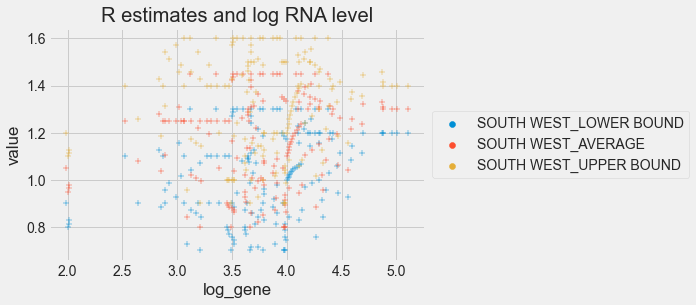

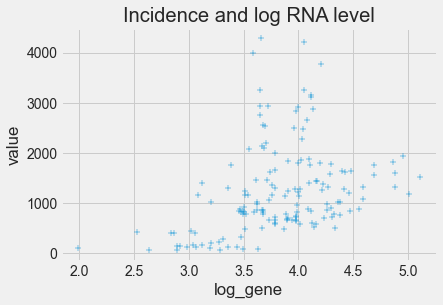

In [465]:
g = sns.scatterplot(data=melted_data, x='log_gene', y='value', hue='variable', marker='+')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('R estimates and log RNA level')

plt.figure()
h = sns.scatterplot(data=melted_data2, x='log_gene', y='value', hue='variable', marker='+', legend=False)
plt.title('Incidence and log RNA level')

In [466]:
# Check number of values under each site
# df3.CIS20CD.value_counts()

# Check number of zero values
# (df == 0).sum()

In [494]:
# Write combined dataset to csv file
combined_dataset.to_csv("Linked Data.csv")

In [496]:
# Write each subset to a separate csv file
for i, outfile in zip(interpolated_subset, ["subset_sw.csv", "subset_se.csv", "subset_ldn.csv",
                                "subset_ee.csv", "subset_em.csv", "subset_wm.csv",
                                "subset_nw.csv", "subset_ne.csv", "subset_yh.csv"]):
    i.to_csv(outfile)